In [68]:
from flair.data import Sentence
from flair.embeddings import BertEmbeddings, ELMoEmbeddings, FastTextEmbeddings, TransformerWordEmbeddings, WordEmbeddings

import gensim
from gensim.models import FastText, Word2Vec
import gensim.downloader as gensim_downloader

import json
import matplotlib.pyplot as plt
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
from nltk import word_tokenize
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder

import torch
import urllib.request
from utils import preprocess_text, plot_word_embeddings
import warnings
warnings.filterwarnings('ignore')

In [4]:
%%time
corpus = pd.read_csv("../corpora/small_amazon_reviews_electronic.csv")
corpus["review"] = corpus.review.apply(lambda x: preprocess_text(x))
texts = [word_tokenize(row["review"]) for idx, row in corpus.iterrows()]

CPU times: user 1min 18s, sys: 1.74 s, total: 1min 20s
Wall time: 1min 43s


<h1>Inhaltsverzeichnis<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Einführung" data-toc-modified-id="Einführung-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Einführung</a></span><ul class="toc-item"><li><span><a href="#Das-Bag-of-Words-Modell" data-toc-modified-id="Das-Bag-of-Words-Modell-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Das Bag-of-Words Modell</a></span></li><li><span><a href="#Grenzen-des-Bag-of-Words-Modells" data-toc-modified-id="Grenzen-des-Bag-of-Words-Modells-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Grenzen des Bag-of-Words Modells</a></span></li></ul></li><li><span><a href="#LSA" data-toc-modified-id="LSA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LSA</a></span></li><li><span><a href="#Word-Embeddings" data-toc-modified-id="Word-Embeddings-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Word Embeddings</a></span><ul class="toc-item"><li><span><a href="#Allgemeines" data-toc-modified-id="Allgemeines-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Allgemeines</a></span></li><li><span><a href="#Word2Vec" data-toc-modified-id="Word2Vec-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Word2Vec</a></span><ul class="toc-item"><li><span><a href="#Vortrainierte-Embeddings-verwenden" data-toc-modified-id="Vortrainierte-Embeddings-verwenden-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Vortrainierte Embeddings verwenden</a></span></li><li><span><a href="#Eigene-Embeddings-trainieren" data-toc-modified-id="Eigene-Embeddings-trainieren-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Eigene Embeddings trainieren</a></span></li></ul></li><li><span><a href="#GloVe" data-toc-modified-id="GloVe-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>GloVe</a></span></li><li><span><a href="#FastText" data-toc-modified-id="FastText-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>FastText</a></span></li></ul></li><li><span><a href="#Contextualised-word-embeddings" data-toc-modified-id="Contextualised-word-embeddings-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Contextualised word embeddings</a></span><ul class="toc-item"><li><span><a href="#Allgemeines" data-toc-modified-id="Allgemeines-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Allgemeines</a></span></li><li><span><a href="#ELMo" data-toc-modified-id="ELMo-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>ELMo</a></span></li><li><span><a href="#BERT" data-toc-modified-id="BERT-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>BERT</a></span></li></ul></li></ul></div>

# Einführung

Das **Natural Language Processing** (kurz: NLP) befasst sich mit Methoden und Verfahren zur maschinellen Verarbeitung von natürlicher Sprache in Form von Worten, Texten oder ganzen Korpora. Bevor jedoch NLP Verfahren wie die Textklassifikation oder das Topic Modelling auf die Textdaten angewendet werden können, müssen diese in eine Darstellungsweise umgewandelt werden, mit der die Verfahren arbeiten können. Die rohen Textdaten werden daher in **Vektoren**, die aus Zahlen bestehen, umgewandelt. Dieser Vorgang nennt sich **Vektorisierung**. Ein Wort wie "Baum" kann dadurch als Vektor aufgefasst werden. Natürlich können auch andere Features aus den Texten als Vektoren dargestellt werden; so ist es auch möglich, einzelne Buchstaben, Phrasen, Sätze, Segmente oder ganze Texte als Features aus den Textdaten zu extrahieren und diese zu vektorisieren. In der folgenden Übersicht werden jedoch vorwiegend Wörter als Features verwendet.

## Das Bag-of-Words Modell

Das wohl einfachste Verfahren zur Darstellung von Wörtern als Vektoren ist das **Bag-of-Words** Modell. Wörter werden hier als eindimensionale Vektoren (= einfache Zahlen) dargestellt, wobei jedes individuelle Wort einen individuellen eindimensionalen Vektor (auch: **Index**) zugeordnet bekommt. Die Zuordnungen jedes einzigartigen Wortes zu seinem Vektor werden in einem *Vokabular* gespeichert. Nun können mithilfe dieses Vokabulars auch ganze Sätze oder sogar Texte dargestellt werden. Dafür wird für jeden Satz/Text ein Vektor gebildet, der die gleiche Länge wie das Vokabular hat. Jedem Eintrag des Vektors wird anhand des Vokabulars ein Wort zugeordnet. Der Satz/Text wird dann als Vektor aus **absoluten Termhäufigkeiten** dargestellt, wo an jeder Stelle, an dem ein Wort aus dem Vokabular in dem Text vorkommt, die Häufigkeit des Wortes in dem jeweiligen Satz/Text steht und an jeder anderen Stelle eine $0$, da es kein einziges Mal vorkommt.[<sup>1</sup>](#fn1) Dies soll im Folgenden anhand eines Code-Beispiels erläutert werden. Zuerst wird das Vokabular aller Texte dargestellt, bei dem die Wörter einem Index zugeordnet werden (es wird ab $0$ gezählt). Danach werden die vektorisierten Sätze/Texte angezeigt.

<hr style="border: 0.1px solid black;"/>
<div id="fn1" style="font-size:8pt; line-height:1; padding-left: 1em; text-indent: -1em"><sup style="font-size:5pt">1</sup> &nbsp;Dies ist nur eine Möglichkeit, die Häufigkeit eines Wortes beim Bag-of-Words Modell darzustellen. Eine weitere Möglichkeit wären <b>binäre Häufigkeiten</b>, bei denen das Vorkommen eines Wortes mit einer $1$ und die Abwesenheit eines Wortes mit einer $0$ gekennzeichnet werden. Um häufigen Wörtern in den Dokumenten weniger Gewicht zu geben, da diese meist einen geringeren Informationsgehalt besitzen, ist es auch möglich, das Bag-of-Words Modell in der Kombination mit dem <b>TF-IDF Maß</b> aus dem Bereich des Information Retrievals zu verwenden, bei dem die Häufigkeit von Worten skaliert wird.</div> 

In [51]:
text = ["ich gehe nachher zur bank, um etwas geld zu holen",
        "ich möchte mich kurz auf die bank setzen",
        "um mir etwas zu essen zu holen, stand ich von der bank auf", 
        "auf der hölzernen bank neben der bank liegt noch geld"]

vectorizer = CountVectorizer()
vector = vectorizer.fit_transform(text)
print(vectorizer.vocabulary_)

{'ich': 10, 'gehe': 6, 'nachher': 16, 'zur': 24, 'bank': 1, 'um': 21, 'etwas': 5, 'geld': 7, 'zu': 23, 'holen': 8, 'möchte': 15, 'mich': 13, 'kurz': 11, 'auf': 0, 'die': 3, 'setzen': 19, 'mir': 14, 'essen': 4, 'stand': 20, 'von': 22, 'der': 2, 'hölzernen': 9, 'neben': 17, 'liegt': 12, 'noch': 18}


In [52]:
print(vector.toarray())

[[0 1 0 0 0 1 1 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1]
 [1 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0]
 [1 1 1 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 2 0]
 [1 2 2 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0]]


## Grenzen des Bag-of-Words Modells

Aufgrund seiner Einfachheit ist das Bag-of-Words Modell leicht verständlich und sehr schnell umsetzbar. Es hat jedoch eine Reihe an Nachteilen, von denen einige im Folgenden kurz erläutert werden:

- **Keine Informationen über Reihenfolge der Wörter.** Beim Bag-of-Words Modell wird jegliche Information über die Reihenfolge der Wörter verworfen, der Kontext eines Wortes bleibt unberücksichtigt. Dies wird auch durch den Namen dieses Modells deutlich: Die Bezeichnung "bag" (deutsch: Sack) soll darauf hinweisen, dass alle Informationen über die Struktur oder Reihenfolge der Wörter im Dokument verworfen werden, da sie metaphorisch in einen "Sack" geworfen werden. Die Reihenfolge lässt sich auch nicht im Nachhinein rekonstruieren. Insgesamt gehen somit sehr viele semantische Informationen verloren. Eine Lösung, bei der die Reihenfolge der Worte berücksichtigt werden kann, ist die Verwendung von **N-Grammen**, **LSA** (Kapitel 2) oder **contextualised word embeddings** (Kapitel 4). 
- **Spärlichkeit von Wortvektoren.** Umso mehr verschiedene Worte in den verwendeten Texten vorkommen, umso größer wird das Vokabular. Dies kann oft zu sehr spärlichen (engl. *sparse*) Wortvektoren führen. Besteht das Vokabular aus 500000 Worten, ein Text aber nur aus 50 verschiedenen Worten, sind nur 0.01% der Stellen des 500000 langen Wortvektors mit Einsen besetzt, der Rest nur mit Nullen. Dies führt dazu, dass eine große Menge an Rechenspeicher für die Verarbeitung der riesigen Matrizen benötigt wird. Weiterhin werden wenige Informationen in sehr großen Repräsentationsräumen benutzt, wodurch es für einige NLP Verfahren und Modelle problematisch ist, diese wenigen Informationen effizient zu nutzen. Eine Lösung bieten dichtbesetzte **Word Embeddings**, die in Kapitel 3 und 4 behandelt werden.
- **Abbildung der Mehrdeutigkeit von Worten**. Wörter können trotz gleicher Schreibweise mehrere Bedeutungen haben, welche sich durch den Kontext des Wortes zeigen können. Dies wird durch das Bag-of-Words Modell nicht abgebildet. Eine mögliche Lösung wäre die Verwendung von **kontextabhängigen Word Embeddings** wie die **ELMo**- oder **BERT-Embeddings** in Kapitel 4.

# LSA

**Latent Semantic Analysis** (kurz: LSA, auch: *Latent Semantic Indexing*) ist ein Verfahren aus dem Bereich des Information Retrievals aus dem Jahre 1990. Bei diesem Verfahren werden Dokumente und Terme (repräsentiert durch eine **Term-Dokument Matrix**) in einem latenten Raum abgebildet, der aus **Konzepten** (oder **Hauptkomponenten**) besteht. Dokumente, die ähnlich zueinander sind, d.h. aus ähnlichen Konzepten bestehen, werden in diesem Raum näher beieinander platziert. Dies wird durch die folgende Grafik deutlich.


![lsa](img/lsa.png)

Grafik von Susan Dumais ([Quelle](http://www.ifis.uni-luebeck.de/~moeller/tuhh-lectures/mmieir-sose-12/05-Latent-Semantic-Analysis.pdf)).

Das Ziel der LSA ist es, die Konzepte innerhalb der Dokumente zu finden. Dabei greift das Verfahren auf eine Technik der linearen Algebra zurück, der **Singulärwertzerlegung** (englisch: Singular Value Decomposition). Die Idee dabei ist, dass die Term-Dokument Matrix aus **Hauptdimensionen**, welche die wichtigen Konzepte der Dokumente beinhalten, und aus weniger aussagekräftigen Dimensionen mit unwichtigen Termen besteht. Mithilfe der Singulärwertzerlegung wird die originale Term-Dokument Matrix in drei Matrizen aufgeteilt, wobei die beiden äußeren Matrizen aus den linken bzw. rechten orthonormalen Eigenvektoren bestehen und die mittlere Matrix eine Diagonalmatrix ist, die die singulären Werte der Originalmatrix enthält. Mit Hilfe dieser Zerlegung kann eine **Approximation** der Originalmatrix mit einer kleiner dimensionierten Matrix erreicht werden. Die singulären Werte in der Diagonalmatrix sind nach ihrer Größe absteigend geordnet. Singulärwerte, die unter einem bestimmten Schwellenwert liegen, werden entfernt. Auch in den anderen Matrizen werden entsprechende Zeilen oder Spalten entfernt. Mit Hilfe der reduzierten Matrizen erhält man durch Matrixmultiplikation die optimale Approximation der Originalmatrix, die kleiner als die originale Term-Dokument Matrix ist, da Informationen aus den weniger aussagekräftigen Dimensionen verworfen wurden. Weiterhin werden bei der Dimensionsreduktion auch ähnliche Konzepte zusammengefasst, so werden z.B. Worte wie "Tür" und "Tor" in einem Konzept zusammengefasst.

Der Vorteil der LSA ist, dass anders als beim Bag-of-Words Modell die **Semantik** der Dokumente wiedergegeben werden kann. Zudem werden **Synonyme** zusammengefasst. Probleme hat LSA jedoch mit der **Polysemie**. Zudem ist der Algorithmus sehr rechenaufwendig.

# Word Embeddings

## Allgemeines

**Word Embeddings** (deutsch: Worteinbettungen) sind die Sammelbezeichnung für eine Reihe von Sprachmodellierungstechniken. Anders als beim Bag-of-Words Modell werden Wörter mit ähnlichen Bedeutungen ähnlich dargestellt, wobei der Kontext der Wörter berücksichtigt wird. Word Embeddings repräsentieren Wörter als Vektoren in einem multidimensionalen semantischen Raum. In diesem Raum werden Wörter, die ähnlich zueinander sind, näher beieinander platziert. Die grundsätzliche Idee von Word Embeddings basiert auf der **Distributionellen Hypothese** von  John Rupert Firth, die besagt, dass die Bedeutung eines Wortes durch sein Umfeld geprägt ist. Wörter, die einen ähnlichen Kontext besitzen, haben eine ähnliche Bedeutung. Anders als vorherige Vektorisierungsmethoden basieren Word Embeddings auf **Vorhersagemodellen** (englisch: **prediction models**)[<sup>2</sup>](#fn2), indem Wörter durch Wahrscheinlichkeiten anstatt durch Häufigkeiten wie beim Bag-of-Words Modell oder bei der Latent Semantic Analysis dargestellt werden. Weiterhin sind die Wortvektoren von Word Embeddings anders als beim Bag-of-Words Modell **dichtbesetzt** (englisch: **dense**) und haben weitaus weniger Dimensionen (100-800 Dimensionen anstatt 100000-1000000, je nach der Größe des Vokabulars). Dadurch haben die Wortvektoren eine viel geringere Größe, bieten trotzdem eine effizientere und komplexere Darstellung der Wörter.

Eine weitere Besonderheit von Word Embeddings ist, dass es mit diesen möglich ist, eine Arithmetik mit Wörtern umzusetzen. So kann mit Wortvektoren "gerechnet" werden. Folgende Gleichungen sind mit Word Embeddings möglich:

`König - Mann + Frau = Königin`<br>

`London - Großbritannien + Deutschland = Berlin`


Word Embeddings wurden ab 2013 durch die Einführung des Algorithmus **Word2Vec** populär, in den Jahren darauf folgten weitere Word Embedding Algorithmen wie **GloVe**, **FastText**, **ELMo** und **BERT**. In der folgenden Tabelle sind die wichtigsten Unterschiede der hier erläuterten Embeddings zusammengefasst, genauere Erläuterungen dieser Embeddings finden sich in den folgenden Kapiteln. Die darauffolgende Abbildung liefert eine Art Stammbaum der verschiedenen Embedding-Arten.



<hr style="border: 0.1px solid black;"/>
<div id="fn2" style="font-size:8pt; line-height:1; padding-left: 1em; text-indent: -1em"><sup style="font-size:5pt">2</sup> &nbsp;Obwohl GloVe eigentlich kein Vorhersagemodell verwendet, unterscheidet sich GloVe trotzdem stark von vorhergehenden, Häufigkeits-basierenden Modellen, weshalb es oft als Vohersagemodell angesehen wird, siehe LEVY et. al. (2015), Improving Distributional Similarity with Lessons Learned from Word Embeddings, https://levyomer.files.wordpress.com/2015/03/improving-distributional-similarity-tacl-2015.pdf (abgerufen am 31.07.2020).</div>

TODO: ausfüllen & mehr, gucken wie anders dargestellt werden kann

<table>
    <th></th>
    <th>Word2Vec</th>
    <th>GloVe</th>
    <th>FastText</th>
    <th>ELMo</th>
    <th>BERT</th>
    <tr>
        <td>Entstehungsjahr</td>
        <td>2013</td>
        <td>2014</td>
        <td>2016</td>
        <td>2018</td>
        <td>2018</td>
    </tr> 
    <tr>
        <td>Out of vocabulary Fehler</td>
        <td>ja</td>
        <td>ja</td>
        <td>nein</td>
        <td>nein</td>
        <td>nein</td>
    </tr> 
    <tr>
        <td>Kontextsensitiv</td>
        <td>nein</td>
        <td>nein</td>
        <td>nein</td>
        <td>ja</td>
        <td>ja</td>
    </tr> 
    <tr>
        <td>gelernte Repräsentationen</td>
        <td>Wörter</td>
        <td>Wörter</td>
        <td>Teilwörter</td>
        <td>Wörter</td>
        <td>Teilwörter</td>
    </tr> 
    <tr>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
    </tr> 
</table>

![](img/all_embeddings.png)

Die Grafik wurde von dieser [Webseite](https://towardsdatascience.com/from-pre-trained-word-embeddings-to-pre-trained-language-models-focus-on-bert-343815627598) entnommen.

## Word2Vec

Die Popularität von Word Embeddings ist vor allem **Word2Vec** geschuldet, welches 2013 von Tomas Mikolov und weiteren Mitgliedern von Google publiziert wurde ([Paper](https://arxiv.org/abs/1301.3781)). Word2Vec basiert auf einem simplen, aber doch effektiven Feedforward Neuronalen Netz. Word2Vec implementiert zwei verschiedene Ansätze zur Berechnung der Wortwahrscheinlichkeiten: **Continous Bag of Words** (**CBOW**) und das **Skip-gram Modell**. 

**Continous Bag of Words** versucht die Wahrscheinlichkeit eines Wortes oder einer Gruppe von Wörtern anhand eines gegebenen Kontext vorauszusagen:

![cbow](img/cbow.png)


Das **Skip-gram Model** funktioniert wie CBOW, nur anders herum. Das Modell versucht, anhand eines gegebenen Wortes den Kontext vorauszusagen:

![skip-gram](img/skipgram.png)

<br>Word2Vec nutzt wahlweise eine dieser Techniken, um aus rohen Textdaten mithilfe eines Neuronalen Netzes Wortvektoren zu erstellen. Dabei kann Word2Vec bei vielen Implementierungen (z.b. bei Gensim) auf zwei Arten verwendet werden: Entweder werden bereits vortrainierte Embeddings geladen oder es werden eigene Embeddings auf eigenen Textdaten trainiert.

### Vortrainierte Embeddings verwenden

Für die Demonstration der Nutzung von vortrainierten Word Embeddings wird ein deutsches Modell verwendet, welches auf Wikipedia- und Zeitungsartikeln trainiert wurde ([Quelle](https://devmount.github.io/GermanWordEmbeddings/)). Als Framework wird **Gensim** verwendet.

In [54]:
pre_w2v = gensim.models.KeyedVectors.load_word2vec_format('german_model.bin', 
                                                          binary=True)

Im folgenden Code werden die 5 ähnlichsten Wörter zu "König" ausgegeben. Alle diese Wörter passen auch thematisch zu "König", sie verbindet alle das Thema "royal" bzw. "Königshaus".

In [55]:
for t in pre_w2v.most_similar('Koenig', topn=5): 
    print(f"{t[0]}: {np.around(t[1], decimals=3)}")

Prinz: 0.786
Koenigs: 0.736
Koenigin: 0.726
Jungkoenig: 0.705
Kaiser: 0.705


Auch das Rechenbeispiel aus Kapitel 3.1 kann mit Word2Vec umgesetzt werden. Addiert man "König" mit "Frau" und subtrahiert "Mann", erhält man Begriffe zum Thema "Königin".

In [56]:
for t in pre_w2v.most_similar(positive=['Koenig', 'Frau'],
                              negative=['Mann'], topn=5):
    print(f"{t[0]}: {np.around(t[1], decimals=3)}")

Koenigin: 0.752
Prinzessin: 0.715
Prinz: 0.688
Jungschuetzenkoenigin: 0.674
Majestaet: 0.659


Weiterhin kann man auch ein Wort mit einer Liste von anderen Wörtern vergleichen und abfragen, welchem Wort aus der Liste das Wort am ähnlichsten ist oder aber man überprüft bei einer Liste von Wörtern, welches Wort nicht passt.

In [59]:
most_similar = pre_w2v.most_similar_to_given('Banane', ['Koenig', 'Berg', 
                                                        'Haus', 'Apfel'])
doesnt_match = pre_w2v.doesnt_match(['Koenig', 'Thron', 'Berg', 'Prinzessin'])
print(f"Welches Wort ist am ähnlichsten zu 'Banane'? -> {most_similar}")
print(f"Welches Wort passt nicht zu den anderen Wörtern? -> {doesnt_match}")

Welches Wort ist am ähnlichsten zu 'Banane'? -> Apfel
Welches Wort passt nicht zu den anderen Wörtern? -> Berg


Plottet man die Wortvektoren der verwandten Wörter (hier die 5 ähnlichsten Wörter), werden die einzelnen Themen sehr gut sichtbar, da sie Cluster bilden und sich von anderen Themen abgrenzen.

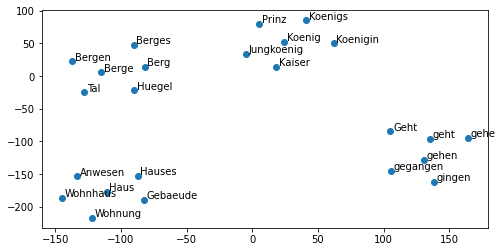

In [58]:
wordlist = ['Haus', 'Berg', 'Koenig', 'gehen']
plot_word_embeddings(pre_w2v, wordlist, figsize=(8,4))

### Eigene Embeddings trainieren

Es ist auch möglich, eigene Embeddings zu trainieren. Dabei muss sich zuvor für die Technik **CBOW** oder **Skip-gram** entschieden werden (wird durch den Parameter `sg`gesteuert). Es wurde der englische Datensatz **Amazon Reviews** verwendet ([Quelle](https://nijianmo.github.io/amazon/index.html)). Dieser wurde für Demonstrationszwecke auf Reviews zu elektronischen Geräten aus dem Jahr 2018 gekürzt. Auch hier passen die ähnlichsten 5 Wörter sehr gut zum ausgewählten Wort *smartphone*.

In [10]:
%%time
word2vec_cbow = Word2Vec(texts, min_count=1, size=100, window=5, sg=0)
word2vec_skipgram = Word2Vec(texts, min_count=1, size=100, window=5, sg=1)

CPU times: user 6min 16s, sys: 5.09 s, total: 6min 21s
Wall time: 3min 30s


In [11]:
word2vec_cbow.wv.most_similar('phone', topn=5)

[('iphone', 0.7328867316246033),
 ('cell', 0.6630538702011108),
 ('phones', 0.6511064767837524),
 ('smartphone', 0.6296558976173401),
 ('computer', 0.6081698536872864)]

## GloVe

**GloVe** (= Global Vectors) wurde 2014 von Pennigton et. al. veröffentlicht ([Paper](https://nlp.stanford.edu/pubs/glove.pdf)). Vor der Veröffentlichung von GloVe ließen sich die Wortvektorisierungsmethoden in zwei Hauptströmungen unterteilen: das Statistik-basierende **LDA**[<sup>3</sup>](#fn3) und das lernbasierte **Word2Vec**. Während LDA Wörter mithilfe von Häufigkeiten in einer Kookkurrenz-Matrix darstellt, verwendet Word2Vec zur Darstellung der Wörter Wortwahrscheinlichkeiten, die mithilfe eines Voraussage-Modells erstellt wurden. **GloVe** verwendet für die Darstellung der Häufigkeiten wie LDA eine Kookkurrenz-Matrix, wobei GloVe die Häufigkeiten vorher normalisiert und mithilfe des Logarithmus "*glättet*" (englisch: *smoothing*). Anders als Word2Vec benutzt es für die Erstellung der Embeddings also keine neuronalen Netze, die erst durch ein Training die Wortbeziehungen erlernen, sondern die Beziehungen werden **global** (daher auch der Name) mithilfe einer Mischung aus maschinellem Lernen und statischen Verfahren aus den Texten gewonnen.

<hr style="border: 0.1px solid black;"/>
<div id="fn3" style="font-size:8pt; line-height:1; padding-left: 1em; text-indent: -1em"><sup style="font-size:5pt">3</sup> &nbsp;<b>LDA</b> steht für "Latent Dirichlet allocation" und ist ein Algorithmus, der Wörter ähnlichen Gruppen anhand der Wahrscheinlichkeit, dass sie zusammen in einem Dokument vorkommen, zuordnet.</div>

Für die Demonstration der Glove-Embeddings wurde die Bibliothek **Flair** verwendet. Jeder Vektor für jedes Token-Embedding hat eine Länge von 100, es wurden jedoch nur die ersten drei Zahlen ausgegeben.

In [22]:
string = "smartphones have a touchscreen"
sentence = Sentence(string, use_tokenizer=True)
glove_embeddings = WordEmbeddings('glove').embed(sentence)

for token in sentence:
    print(f"'{token.text}': {token.embedding[:3]} " +
          f"(Vektorlänge: {len(token.embedding)})")

'smartphones': tensor([-0.2138, -0.3245,  0.2806]) (Vektorlänge: 100)
'have': tensor([0.1571, 0.6561, 0.0021]) (Vektorlänge: 100)
'a': tensor([-0.2709,  0.0440, -0.0203]) (Vektorlänge: 100)
'touchscreen': tensor([-0.7974,  0.1240,  0.7148]) (Vektorlänge: 100)


## FastText

**Word2Vec** und **GloVe** haben Probleme damit, unbekannte Wörter zu verarbeiten. Dieser Fehler nennt sich **out of vocabulary** (**OOV**), da das Wort nicht im bekannten Vokabular der Embeddings vorkommt. Es ist zwar möglich, unbekannten Wörtern ein zufälliges Embedding zuzuweisen, jedoch ist dies vor allem problematisch, wenn das unbekannte Wort ein Schlüsselwort im untersuchten Text ist. Eine Embedding Verfahren, welches das OOV Problem löst, ist **FastText**, welches 2016 von Bojanowski et. al. veröffentlicht wurde ([Paper](https://arxiv.org/abs/1607.04606)). FastText löst das OOV-Problem, indem es Wörter mithilfe von Buchstaben N-Grammen in einzelne Teilwörter aufteilt. Während des Trainings lernt FastText die Buchstaben N-Gramme der Teilwörter. Bei einem unbekannten Wort wird ein Embedding dieses Wortes erzeugt, indem der Mittelwert der Vektorrepräsentationen der verschiedenen Buchstaben N-Gramm-Embeddings gebildet wird. Zwar kann FastText so mit unbekannten Wörtern umgehen, eine optimale Lösung für das Problem ist dies jedoch nicht, da Wörter zwar aus ähnlichen Buchstaben N-Gramm-Bestandteilen bestehen, sich aber semantisch trotzdem stark voneinander unterscheiden können.

Im Folgenden wird die Funktionsweise von FastText-Embeddings anhand eines Beispielsatzes demonstriert. Wie bei den GloVe-Embeddings auch wird hier die Bibliothek **Flair** verwendet. Der folgende Code erzeugt sowohl für das FastText-Embedding als auch für das GloVe-Embedding einen OOV-Fehler für das Wort "tensorflow", dargestellt durch einen Wortvektor, der nur aus Nullen besteht.

In [44]:
string2 = "tensorflow is a library"
sentence2 = Sentence(string2, use_tokenizer=True)
sentence3 = Sentence(string2, use_tokenizer=True)
glove_embedding2 = WordEmbeddings('glove').embed(sentence2)
fasttext_embedding2 = WordEmbeddings('en').embed(sentence3)

for token1, token2 in zip(sentence2, sentence3):
    print(f"[GloVe] '{token1.text}': {token1.embedding[:3]} " +
          f"(Vektorlänge: {len(token1.embedding)})")
    print(f"[FastText] '{token2.text}': {token2.embedding[:3]} " +
          f"(Vektorlänge: {len(token2.embedding)})")
    break

[GloVe] 'tensorflow': tensor([0., 0., 0.]) (Vektorlänge: 100)
[FastText] 'tensorflow': tensor([0., 0., 0.]) (Vektorlänge: 300)


Um keinen OOV-Fehler zu erzeugen, muss anstatt der Klasse `WordEmbeddings` die Klasse `FastTextEmbeddings` in Kombination mit einem selbst heruntergeladen englischen Model verwendet werden ([Link zum Modell](https://fasttext.cc/docs/en/pretrained-vectors.html)). Nun kann das Wort "tensorflow" dargestellt werden.[<sup>4</sup>](#fn4)

<hr style="border: 0.1px solid black;"/>
<div id="fn4" style="font-size:8pt; line-height:1; padding-left: 1em; text-indent: -1em"><sup style="font-size:5pt">4</sup> &nbsp;Da die FastText-Embeddings sehr groß sind, wurden die Wortvektoren extern berechnet, hier werden nur die Ergebnisse angezeigt.</div>

In [67]:
# sentence4 = Sentence(string2, use_tokenizer=True)
# fasttext_embedding = FastTextEmbeddings('cc.en.300.bin').embed(sentence4)
with open("fasttext.json", "r") as f:
    sentence4_worddict = json.load(f)
    for k, v in sentence4_worddict.items():
         print(f"'{k}': {np.around(torch.tensor(v), decimals=3)} ")

'tensorflow': tensor([-0.0790, -0.0390,  0.0030]) 
'is': tensor([-0.0980, -0.2080, -0.1040]) 
'a': tensor([ 0.0880, -0.4960, -0.0500]) 
'library': tensor([ 0.0000,  0.0320, -0.0270]) 


# Contextualised word embeddings

## Allgemeines

Seit ihrer Einführung wurden vortrainierte Word Embeddings als bevorzugte Vektorisierungsmethode für Neuronale Netze verwendet. Word Embeddings wie Word2Vec, GloVe oder FastText haben jedoch das Problem, dass sie **statische** Wortrepräsentationen liefern. Das Embedding eines Wortes ist immer gleich, egal in welchem Kontext es auftaucht. 

`Ich sitze auf der Bank.`<br>

`Ich hole Geld von der Bank.`

Betrachtet man die beiden Beispielsätze, hat das Wort "Bank" eine unterschiedliche Bedeutung (Sitzgelegenheit/Möbelstück und Kreditinstitut), wird von den statischen Word Embeddings aber als gleicher Wortvektor aufgefasst. Statische Word Embeddings haben zwei Limitierungen:

1. Die Bedeutung eines Wortes, die sich durch den Kontext ergibt, wird ignoriert.
2. Semantische Phänomene wie langfristige Abhängigkeiten oder die Kompositionalität eines Satzes bleiben unberücksichtigt.


Eine Lösung bieten die in den letzten Jahren veröffentlichten **contextualised word embeddings** wie **ELMo** oder **BERT**. Diese Word Embeddings bieten eine **dynamische** Wortrepräsentation, sodass Worte, die die gleiche Schreibweise besitzen, durch unterschiedliche Vektoren dargestellt werden können, je nachdem in welchem Kontext sie sich befinden oder in welcher Reihenfolge sie vorkommen.

**Contextualised word embeddings** unterscheiden sich von den statischen Word Embeddings ebenfalls in der Hinsicht, dass das Modell, mit denen die Embeddings trainiert wurden, für weitere Anwendungen der Embeddings verwendet werden muss. Möchte man beispielsweise ein  Neuronales Netz trainieren, reicht es bei statischen Word Embeddings, lediglich die Wortvektoren in einem Embedding Layer zu verwenden. Bei den kontextualisierten Word Embeddings wird zusätzlich das Modell benötigt, da diese den Wortvektor anhand der umliegenden Wörter erstellen. Dies wird durch die folgende Grafik deutlich:


![](img/difference_embeddings.png)

Die Grafik wurde von dieser [Webseite](https://www.quora.com/What-were-the-most-significant-Natural-Language-Processing-advances-in-2018/answer/Ajit-Rajasekharan) entnommen.

## ELMo

**ELMo** (= Embeddings from Language Models) wurde Anfang 2018 von Peters et. al. veröffentlicht ([Paper](https://arxiv.org/abs/1802.05365)). Für das Training von Embeddings verwendet ELMo ein **tiefes bidirektionales LSTM Language Model**. Language Models werden dazu verwendet, anhand von vorangegangen Wörtern das nächste Wort in einem Satz vorauszusagen. Dazu müssen Language Models sowohl die semantischen als auch die syntaktischen Eigenschaften von Wörtern kodieren, welches sie zu geeignten Modellen für die Darstellung von Wörtern macht. Die Bidirektionalität erlaubt es ELMo, nicht nur vorhergehende Wörter, sondern auch nachfolgende Wörter für die Vorausage eines Wortes zu verwenden. ELMo agiert beim Training nicht auf der Wortebene, sondern verwendet ähnlich wie FastText Buchstabenvektoren, womit Wörter unter Benutzung eines Lernmodells oder der Mittelwertsbildung der Wortvektoren gebaut und das OOV-Problem umgangen werden kann. Trotzdem sind die ausgegeben Vektoren letztendlich Wortvektoren und keine Buchstaben- oder Teilwortvektoren.

Im Folgenden wird anhand eines Beispielsatzes die Funktionsweise der ELMo-Embedding mithilfe der Bibliothek **Flair** demonstriert. Beim Beispielsatz hat das Wort "apple" mehrere Bedeutungen, einmal ist das Unternehmen gemeint und einmal die Frucht. Vergleicht man die beiden Vektoren, erkennt man, dass diese durch unterschiedliche Vektoren dargestellt werden. Anders als bei vorherigen Embedding-Verfahren wird die Mehrdeutigkeit also dargestellt.

In [69]:
sentence5 = Sentence('apple is a company but an apple is also a fruit')
ELMoEmbeddings("original").embed(sentence5)

elmo_tensors = []

for token in sentence5:
    if token.text == "apple":
        elmo_tensors.append(token.embedding)
    print(f"'{token.text}': {token.embedding[:3]} " +
          f"(Vektorlänge: {len(token.embedding)})")

'apple': tensor([0.1444, 0.0678, 0.3774]) (Vektorlänge: 3072)
'is': tensor([ 0.1915,  0.2300, -0.2894]) (Vektorlänge: 3072)
'a': tensor([ 0.1040,  0.1229, -0.0706]) (Vektorlänge: 3072)
'company': tensor([ 0.6496,  0.0804, -0.5390]) (Vektorlänge: 3072)
'but': tensor([-0.2404, -0.2742, -0.2190]) (Vektorlänge: 3072)
'an': tensor([ 0.0797,  0.1992, -0.0695]) (Vektorlänge: 3072)
'apple': tensor([0.1444, 0.0678, 0.3774]) (Vektorlänge: 3072)
'is': tensor([ 0.1915,  0.2300, -0.2894]) (Vektorlänge: 3072)
'also': tensor([ 0.8475, -0.2688,  0.2739]) (Vektorlänge: 3072)
'a': tensor([ 0.1040,  0.1229, -0.0706]) (Vektorlänge: 3072)
'fruit': tensor([-0.5279,  0.3975,  0.8766]) (Vektorlänge: 3072)


In [70]:
diff = elmo_tensors[1] - elmo_tensors[0]
print("Die Vektoren der beiden unterschiedlichen Bedeutungen " +
      "von 'apple' unterscheiden sich bei ELMo in " +
      f"{len([i for i in diff.tolist() if i != 0])} von 3072 Stellen.")

Die Vektoren der beiden unterschiedlichen Bedeutungen von 'apple' unterscheiden sich bei ELMo in 2045 von 3072 Stellen.


## BERT

**BERT** (= Bidirectional Encoder Representations from Transformers) gehört wie **ELMo** zu den **contextualised word embeddings** und wurde Ende 2018 von Devlin et. al. veröffentlicht ([Paper](https://arxiv.org/abs/1810.04805)). BERT baut auf der bidirektionalen Idee von ELMo auf, verwendet anstatt einem LSTM-Modell jedoch ein **Transformers**-Modell um die Embeddings zu berechnen. Beim Training verwendete BERT den sogenannten **Attention**-Mechanismus des **Transformers**-Modell, der es erlaubt, relevanten Worten in einer Sequenz mehr Bedeutung als anderen Worten zuzuschreiben. Anders als vorhergehende Implementierungen des Attention-Mechanismus verwendete BERT anstatt eines unidirektionalen einen **bidirektionalen** Ansatz, bei dem nicht nur nachfolgende, sondern auch vorhergehende Wörter betrachtet wurden. Der bidirektionale Ansatz ist jedoch in dem Sinne problematisch, dass er Wörtern erlaubt, sich indirekt "selbst zu sehen", wodurch das Modell in der Lage wäre, das Zielwort relativ einfach vorauszusagen.
    
Zur Lösung dieses Problems benutzte BERT die Konzepte **Next Sentence Prediction** und **Masked Language Modeling**. Bei der **Next Sentence Prediction** (NSP) prüft BERT, ob ein nachfolgender Satz kontextuell zum vorherigen Satz passt. Das **Masked Language Modeling** (MLM) ist eine spezielle Form des Language Modelings. Dabei werden zufällig 15% der Wörter in jedem Satz der Trainingsdaten ausgewählt, von denen wiederum 80% durch ein spezielles Maskierungstoken ausgetauscht, 10% durch ein zufälliges Wort aus dem Vokabular des Korpus ersetzt und 10% der Wörter nicht verändert werden. BERT versuchte dann im Training, die ausgewählten Tokens vorauszusagen, wozu es die umliegenden, nicht maskierten Wörter verwendete. Dadurch berücksichtigen die gelernten Gewichte anders als Word2Vec oder GloVe den Kontext eines Wortes, was es BERT erlaubt, zwischen mehrdeutigen Wörtern zu unterscheiden. Um das OOV-Problem zu umgehen, verwendete BERT ähnlich wie FastText keine ganzen Wörter, sondern Teilwörter, mithilfe derer verschiedene Wörter zusammengebaut werden können.
   
Im Folgenden wird anhand eines Beispielsatzes die Funktionsweise der BERT-Embedding mithilfe der Bibliothek **Flair** demonstriert. Beim Beispielsatz hat das Wort "apple" mehrere Bedeutungen, einmal ist das Unternehmen gemeint und einmal die Frucht. Vergleicht man die beiden Vektoren, erkennt man, dass diese durch unterschiedliche Vektoren dargestellt werden. Anders als noch bei ELMo unterscheiden sich diese Vektoren vollends voneinander, sie haben keine gemeinsamen Stellen.

In [49]:
sentence6 = Sentence('apple is a company but an apple is also a fruit')
BertEmbeddings().embed(sentence6)

bert_tensors = []

for token in sentence6:
    if token.text == "apple":
        bert_tensors.append(token.embedding)
    print(f"'{token.text}': {token.embedding[:3]} " +
          f"(Vektorlänge: {len(token.embedding)})")

'apple': tensor([ 0.3007,  0.4433, -0.2990]) (Vektorlänge: 3072)
'is': tensor([-0.1345, -0.1533, -0.1418]) (Vektorlänge: 3072)
'a': tensor([-0.0250, -0.0645,  0.1348]) (Vektorlänge: 3072)
'company': tensor([ 0.2446, -0.1140,  0.0695]) (Vektorlänge: 3072)
'but': tensor([-0.2657, -0.2901,  0.1341]) (Vektorlänge: 3072)
'an': tensor([-0.1693,  1.0000, -0.0986]) (Vektorlänge: 3072)
'apple': tensor([ 0.0220,  0.8081, -0.1181]) (Vektorlänge: 3072)
'is': tensor([-0.3891,  0.3975,  0.1520]) (Vektorlänge: 3072)
'also': tensor([-0.7347, -0.0557, -0.2733]) (Vektorlänge: 3072)
'a': tensor([-0.1067,  0.3567,  0.2085]) (Vektorlänge: 3072)
'fruit': tensor([-0.1865,  0.4674, -0.2058]) (Vektorlänge: 3072)


In [50]:
diff = bert_tensors[1] - bert_tensors[0]
print("Die Vektoren der beiden unterschiedlichen Bedeutungen " +
      "von 'apple' unterscheiden sich bei BERT in " +
      f"{len([i for i in diff.tolist() if i != 0])} von 3072 Stellen.")

Die Vektoren der beiden unterschiedlichen Bedeutungen von 'apple' unterscheiden sich bei BERT in 3072 von 3072 Stellen.
